In [1]:
### header ###
__author__ = "Hunter Bennett"
__license__ = "BSD"
__email__ = "hunter.r.bennett@gmail.com"
%load_ext autoreload
%autoreload 2
### imports ###
import sys
%matplotlib inline
import os
import re
import glob
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt 
import seaborn as sns
matplotlib.rcParams['savefig.dpi'] = 200
sns.set(font_scale=1)
sns.set_context('talk')
sns.set_style('white')

# import custom functions
import sys
sys.path.insert(0, '/home/h1bennet/code/')
from hbUtils import ngs_qc, quantile_normalize_df
from plotting_scripts import label_point, pca_rpkm_mat, get_diff_volcano
from homer_preprocessing import read_annotated_peaks, import_homer_diffpeak, pull_comparisons_get_diff
from gene_expression_plots import survey_strain_amln_gene_exp, survey_strain_ccl4_gene_exp

In [2]:
matplotlib.rcParams.keys()

/gpfs/data01/glasslab/home/h1bennet/.conda/envs/dataviz/lib/python3.7/_collections_abc.py:705: MatplotlibDeprecationWarning: 
The examples.directory rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2. In the future, examples will be found relative to the 'datapath' directory.
  return '{0.__class__.__name__}({0._mapping!r})'.format(self)


KeysView(RcParams({'_internal.classic_mode': False,
          'agg.path.chunksize': 0,
          'animation.avconv_args': [],
          'animation.avconv_path': 'avconv',
          'animation.bitrate': -1,
          'animation.codec': 'h264',
          'animation.convert_args': [],
          'animation.convert_path': 'convert',
          'animation.embed_limit': 20.0,
          'animation.ffmpeg_args': [],
          'animation.ffmpeg_path': 'ffmpeg',
          'animation.frame_format': 'png',
          'animation.html': 'none',
          'animation.html_args': [],
          'animation.writer': 'ffmpeg',
          'axes.autolimit_mode': 'data',
          'axes.axisbelow': True,
          'axes.edgecolor': '.15',
          'axes.facecolor': 'white',
          'axes.formatter.limits': [-7, 7],
          'axes.formatter.min_exponent': 0,
          'axes.formatter.offset_threshold': 4,
          'axes.formatter.use_locale': False,
          'axes.formatter.use_mathtext': False,
          'a

In [3]:
#### PLOTTING PARAMETERS FOR MANUSCRIPT ####
# # get matplotlib to save readable fonts
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
# matplotlib.rcParams['font.family'] = "sans-serif"
matplotlib.rcParams['font.sans-serif'] = "Arial"
matplotlib.rcParams['font.size'] = 6
matplotlib.rcParams['xtick.labelsize'] = 6
matplotlib.rcParams['ytick.labelsize'] = 6

# line widths
matplotlib.rcParams['axes.linewidth'] = 1
matplotlib.rcParams['xtick.major.width'] = 1
matplotlib.rcParams['ytick.major.width'] = 1

# adjust defualt color for plots to black
# normal default is a dark gray
COLOR = 'black'
matplotlib.rcParams['text.color'] = COLOR
matplotlib.rcParams['axes.labelcolor'] = COLOR
matplotlib.rcParams['xtick.color'] = COLOR
matplotlib.rcParams['ytick.color'] = COLOR
matplotlib.rcParams['axes.edgecolor'] = COLOR

#### END PLOTTING PARAMTERS ####

In [4]:
controlDirectory = '/home/h1bennet/strains/data/ATAC/control_cohort2/'
lpsDirectory = '/home/h1bennet/strains/data/ATAC/Leptin_6hours/'
workingDirectory = '/home/h1bennet/strains/results/11_Strains_Leptin_6h_ATAC//'
if not os.path.isdir(workingDirectory):
    os.mkdir(workingDirectory)
os.chdir(workingDirectory)

# Process for motif calling with Homer

For motif calling its unclear whether it would be ideal to take all peaks activated in C57 compared to any other strain and look for motif enrichment or whether it would be better to look at motifs only in a pairwise fashion. I probably lean towards looking at any peak activated in C57 since they should be enriched for strain specific motifs.

In [7]:
if not os.path.isdir('./motif_calling/'):
    os.mkdir('./motif_calling/')

Ty pointed out that running annotatePeaks.pl on a peak file adjusts the peak size to what is being annotated :O so we have to pull the original coordinates out of the ATAC file. The ATAC peak file from O'young's pipeline has an average peak size of about 270 so they are a little bigger than the NFR we like for ATAC seq. I'm unsure whether the best thing to do here would be to make them all 200 bp based on the center of the peak or if we should just use the merged peak sizes.

In the ATAC-seq pipeline we only consider the peaks within 200 bp of the peak center when calling differential peaks, and annotate peaks resizes the peak around the center during processing, so we can just read in the annotated peak file rather than resizing the peaks manually!

However, the code to resize peaks is still available in the H3K27Ac pipeline should you need it!

### Select distal differential peaks for motif analysis

# Extract target peaks

Reminder that "activated" peaks in the control and LPS are activated in C57

In [11]:
convert_dict = {'Start': int,
                'End': int}

# set p value and log2fcs
pval = 0.05
log2fc = np.log2(2)

peak_dict = {}

for i in glob.glob('./peakQuan/*diff_output.txt'):
    diff_peak, peaks, peak_mat, peak_mat_quant = import_homer_diffpeak(
        i,
        './peakQuan/allNormTags.txt')
    
    # extract comparison name
    comp_name = i.split('/')[-1].split('_')[0]
    
    # extract distal peaks only
    diff_peak_distal = diff_peak.loc[np.abs(diff_peak.loc[:, 'Distance to TSS']) >= 3000, :]
    
    # log2fc is in position -3, adj p value is in position -1
    # positive peaks are up in NASH, negative peaks are down in NASH
    act = diff_peak.loc[(diff_peak.iloc[:, -3] >= log2fc) & (diff_peak.iloc[:, -1] < pval), :].index.tolist()
    rep = diff_peak.loc[(diff_peak.iloc[:, -3] <= -log2fc) & (diff_peak.iloc[:, -1] < pval), :].index.tolist()
    
    # activated peaks stored in the [0] position.
    peak_dict[i.split('/')[-1].split('_')[0].replace('./','')] = [act, rep]
    
    # save to list
    print(comp_name)
    print('n activated peaks:',diff_peak.reindex(act).dropna(how='all').shape[0])
    diff_peak.reindex(act).dropna(how='all').iloc[:, :4].astype(convert_dict).to_csv(
    './motif_calling/%s_act_log2fc_%.1f_pval_%.2f.txt' % (comp_name, log2fc, pval),
    sep='\t')
    
    print('n distal activated peaks:',diff_peak_distal.reindex(act).dropna(how='all').shape[0])
    diff_peak_distal.reindex(act).dropna(how='all').iloc[:, :4].astype(convert_dict).to_csv(
    './motif_calling/%s_distal_act_log2fc_%.1f_pval_%.2f.txt' % (comp_name, log2fc, pval),
    sep='\t')
    
    print('n repressed peaks:',diff_peak.reindex(rep).dropna(how='all').shape[0])
    diff_peak.reindex(rep).dropna(how='all').iloc[:, :4].astype(convert_dict).to_csv(
    './motif_calling/%s_rep_log2fc_%.1f_pval_%.2f.txt' % (comp_name, log2fc, pval),
    sep='\t')
    
    print('n distal repressed peaks:',diff_peak_distal.reindex(rep).dropna(how='all').shape[0])
    diff_peak_distal.reindex(rep).dropna(how='all').iloc[:, :4].astype(convert_dict).to_csv(
    './motif_calling/%s_distal_rep_log2fc_%.1f_pval_%.2f.txt' % (comp_name, log2fc, pval),
    sep='\t')

annotatePeaks all peaks (89968, 38)
getDiffExpression selected transcripts (84876, 28)
annotatePeaks selected peaks (84876, 38)
c57bl6j
n activated peaks: 1938
n distal activated peaks: 1646
n repressed peaks: 3559
n distal repressed peaks: 1056
annotatePeaks all peaks (89968, 38)
getDiffExpression selected transcripts (84876, 28)
annotatePeaks selected peaks (84876, 38)
aj
n activated peaks: 2018
n distal activated peaks: 1612
n repressed peaks: 3928
n distal repressed peaks: 1253
annotatePeaks all peaks (89968, 38)
getDiffExpression selected transcripts (84876, 27)
annotatePeaks selected peaks (84876, 38)
balbcj
n activated peaks: 574
n distal activated peaks: 427
n repressed peaks: 2645
n distal repressed peaks: 627


Also look at comparative peak sets

In [7]:
# # lps induced peaks
# lps_induced_consensus = set(peak_dict['c57bl6j'][0]).intersection(peak_dict['balbcj'][0])
# lps_induced_c57bl6j_spec = set(peak_dict['c57bl6j'][0]).difference(peak_dict['balbcj'][0])
# lps_induced_balbcj_spec = set(peak_dict['balbcj'][0]).difference(peak_dict['c57bl6j'][0])

# # lps repressed peaks
# lps_repressed_consensus = set(peak_dict['c57bl6j'][1]).intersection(peak_dict['balbcj'][1])
# lps_repressed_c57bl6j_spec = set(peak_dict['c57bl6j'][1]).difference(peak_dict['balbcj'][1])
# lps_repressed_balbcj_spec = set(peak_dict['balbcj'][1]).difference(peak_dict['c57bl6j'][1])

# # c57bl6j specific peaks
# c57bl6j_spec_shared = set(peak_dict['control'][0]).intersection(peak_dict['lps2h'][0])
# c57bl6j_spec_control_only = set(peak_dict['control'][0]).difference(peak_dict['lps2h'][0])
# c57bl6j_spec_lps_only = set(peak_dict['lps2h'][0]).difference(peak_dict['control'][0])

# # balbcj specific peaks
# balbcj_spec_shared = set(peak_dict['control'][1]).intersection(peak_dict['lps2h'][1])
# balbcj_spec_control_only = set(peak_dict['control'][1]).difference(peak_dict['lps2h'][1])
# balbcj_spec_lps_only = set(peak_dict['lps2h'][1]).difference(peak_dict['control'][1])

In [8]:
# list_o_lists = [lps_induced_consensus, lps_induced_c57bl6j_spec,
#                 lps_induced_balbcj_spec, lps_repressed_consensus,
#                 lps_repressed_c57bl6j_spec, lps_repressed_balbcj_spec,
#                 c57bl6j_spec_shared, c57bl6j_spec_control_only,
#                 c57bl6j_spec_lps_only, balbcj_spec_shared,
#                 balbcj_spec_control_only, balbcj_spec_lps_only]

# list_o_names = ['lps_induced_consensus', 'lps_induced_c57bl6j_spec',
#                 'lps_induced_balbcj_spec', 'lps_repressed_consensus',
#                 'lps_repressed_c57bl6j_spec', 'lps_repressed_balbcj_spec',
#                 'c57bl6j_spec_shared', 'c57bl6j_spec_control_only',
#                 'c57bl6j_spec_lps_only', 'balbcj_spec_shared',
#                 'balbcj_spec_control_only', 'balbcj_spec_lps_only']

In [9]:
# df, mat = read_annotated_peaks('./merged_peaks/ann_raw_idr_peaks_merged.txt')
# df_distal = df.loc[np.abs(df.loc[:, 'Distance to TSS']) >= 3000, :]

# for peak_list, list_name in zip(list_o_lists, list_o_names):
#     df.reindex(peak_list).dropna(how='all').iloc[:, :4].astype(convert_dict).to_csv(
#         './motif_calling/%s_log2fc_%.1f_pval_%.2f.txt' % (list_name, log2fc, pval),
#         sep='\t')
        
#     df_distal.reindex(peak_list).dropna(how='all').iloc[:, :4].astype(convert_dict).to_csv(
#         './motif_calling/%s_distal_log2fc_%.1f_pval_%.2f.txt' % (list_name, log2fc, pval),
#         sep='\t')

# Save peaks for motif calling

### Call motifs using homer

In [14]:
strain_dict = {'c57bl6j': 'c57bl6j',
               'balbcj': 'balbcj',
               'aj': 'aj'}

all_peaks = './peakQuan/allNormTags.txt'

In [15]:
glob.glob('./motif_calling/*txt')

['./motif_calling/balbcj_rep_log2fc_1.0_pval_0.05.txt',
 './motif_calling/c57bl6j_distal_act_log2fc_1.0_pval_0.05.txt',
 './motif_calling/c57bl6j_distal_rep_log2fc_1.0_pval_0.05.txt',
 './motif_calling/c57bl6j_act_log2fc_1.0_pval_0.05.txt',
 './motif_calling/c57bl6j_rep_log2fc_1.0_pval_0.05.txt',
 './motif_calling/aj_act_log2fc_1.0_pval_0.05.txt',
 './motif_calling/aj_distal_act_log2fc_1.0_pval_0.05.txt',
 './motif_calling/aj_rep_log2fc_1.0_pval_0.05.txt',
 './motif_calling/aj_distal_rep_log2fc_1.0_pval_0.05.txt',
 './motif_calling/balbcj_act_log2fc_1.0_pval_0.05.txt',
 './motif_calling/balbcj_distal_act_log2fc_1.0_pval_0.05.txt',
 './motif_calling/balbcj_distal_rep_log2fc_1.0_pval_0.05.txt']

In [16]:
with open('./findMotifs_differential.sh', 'w') as f:
    
    for peakfile in np.sort(glob.glob('./motif_calling/aj*rep*.txt')):
        strain = peakfile.split('/')[-1].split('_')[0]
        call = ['/home/vlink/code/marge/bin/MMARGE.pl', 'denovo_motifs',
                peakfile, 'mm10', peakfile.replace('.txt', '_motifs'),
                '-bg', all_peaks,
                '-len 8,10,12,14,16', '-fg_strain', strain_dict[strain],
                '-bg_strain', strain_dict[strain], '-p 16\n\n']
        f.write(' '.join(call))    
    
    for peakfile in np.sort(glob.glob('./motif_calling/balbcj*rep*.txt')):
        strain = peakfile.split('/')[-1].split('_')[0]
        call = ['/home/vlink/code/marge/bin/MMARGE.pl', 'denovo_motifs',
                peakfile, 'mm10', peakfile.replace('.txt', '_motifs'),
                '-bg', all_peaks,
                '-len 8,10,12,14,16', '-fg_strain', strain_dict[strain],
                '-bg_strain', strain_dict[strain], '-p 16\n\n']
        f.write(' '.join(call))
        
    for peakfile in np.sort(glob.glob('./motif_calling/c57bl6j*rep*.txt')):
        strain = peakfile.split('/')[-1].split('_')[0]
        call = ['/home/vlink/code/marge/bin/MMARGE.pl', 'denovo_motifs',
                peakfile, 'mm10', peakfile.replace('.txt', '_motifs'),
                '-bg', all_peaks,
                '-len 8,10,12,14,16', '-fg_strain', strain_dict[strain],
                '-bg_strain', strain_dict[strain], '-p 16\n\n']
        f.write(' '.join(call))
        
f.close()

In [17]:
with open('./findMotifs_differential_nobg_nodenovo.sh', 'w') as f:
    
    for peakfile in np.sort(glob.glob('./motif_calling/aj*rep*.txt')):
        strain = peakfile.split('/')[-1].split('_')[0]
        call = ['/home/vlink/code/marge/bin/MMARGE.pl', 'denovo_motifs',
                peakfile, 'mm10', peakfile.replace('.txt', '_motifs_nobg_nodenovo'),
                '-nomotif', '-fg_strain', strain_dict[strain],
                '-bg_strain', strain_dict[strain], '-p 8\n\n']
        f.write(' '.join(call))
        
    for peakfile in np.sort(glob.glob('./motif_calling/balbcj*rep*.txt')):
        strain = peakfile.split('/')[-1].split('_')[0]
        call = ['/home/vlink/code/marge/bin/MMARGE.pl', 'denovo_motifs',
                peakfile, 'mm10', peakfile.replace('.txt', '_motifs_nobg_nodenovo'),
                '-nomotif', '-fg_strain', strain_dict[strain],
                '-bg_strain', strain_dict[strain], '-p 8\n\n']
        f.write(' '.join(call))
        
    for peakfile in np.sort(glob.glob('./motif_calling/c57bl6j*rep*.txt')):
        strain = peakfile.split('/')[-1].split('_')[0]
        call = ['/home/vlink/code/marge/bin/MMARGE.pl', 'denovo_motifs',
                peakfile, 'mm10', peakfile.replace('.txt', '_motifs_nobg_nodenovo'),
                '-nomotif', '-fg_strain', strain_dict[strain],
                '-bg_strain', strain_dict[strain], '-p 8\n\n']
        f.write(' '.join(call))


# Aggregate results - Homer

In [13]:
np.sort(glob.glob('./motif_calling/*motifs/knownResults.txt'))

array(['./motif_calling/balbcj_act_log2fc_1.0_pval_0.05_motifs/knownResults.txt',
       './motif_calling/balbcj_distal_act_log2fc_1.0_pval_0.05_motifs/knownResults.txt',
       './motif_calling/balbcj_distal_rep_log2fc_1.0_pval_0.05_motifs/knownResults.txt',
       './motif_calling/balbcj_log2fc_1.0_pval_0.05_motifs/knownResults.txt',
       './motif_calling/balbcj_rep_log2fc_1.0_pval_0.05_motifs/knownResults.txt',
       './motif_calling/balbcj_spec_control_only_distal_log2fc_1.0_pval_0.05_motifs/knownResults.txt',
       './motif_calling/balbcj_spec_control_only_log2fc_1.0_pval_0.05_motifs/knownResults.txt',
       './motif_calling/balbcj_spec_lps_only_distal_log2fc_1.0_pval_0.05_motifs/knownResults.txt',
       './motif_calling/balbcj_spec_lps_only_log2fc_1.0_pval_0.05_motifs/knownResults.txt',
       './motif_calling/balbcj_spec_shared_distal_log2fc_1.0_pval_0.05_motifs/knownResults.txt',
       './motif_calling/balbcj_spec_shared_log2fc_1.0_pval_0.05_motifs/knownResults.txt',
   

In [14]:
known_motif_pval_dict = {}
for f in np.sort(glob.glob('./motif_calling/*/knownResults.txt')):
    # read in signifance values using pandas
    frame = pd.read_csv(f, sep='\t', index_col=0)
    
    # remove duplicates
    frame = frame[~frame.index.duplicated(keep='first')]
    pval = frame.iloc[:, 2]
    
    # extract name of sample
    sample = f.split('/')[2]
    
    # store in dict
    known_motif_pval_dict[sample] = pval    
    
# create data frame
known_motif_pval_frame = pd.DataFrame(known_motif_pval_dict)

# sort by average p value
known_motif_pval_frame = known_motif_pval_frame.reindex(known_motif_pval_frame.mean(axis=1).sort_values().index.tolist())

known_motif_pval_frame.to_csv('./homer_known_motifs_all.txt', sep='\t')

# Plot known motif results

## Plot intersection motifs

In [35]:
top_n = 15

tmp_frame = known_motif_pval_frame.loc[:, known_motif_pval_frame.columns.str.contains('lps_induced')]
tmp_frame = tmp_frame.loc[:, ~tmp_frame.columns.str.contains('nobg_nodenovo')]
tmp_frame = tmp_frame.loc[:, ~tmp_frame.columns.str.contains('consensus')]

# sort by new mean
tmp_frame = tmp_frame.reindex(tmp_frame.mean(axis=1).sort_values(ascending=True).index.tolist())


top_motifs = []
for col in tmp_frame.columns:
    top_motifs.extend(tmp_frame.sort_values(col).index.tolist()[:top_n])
    
top_motifs = set(top_motifs)

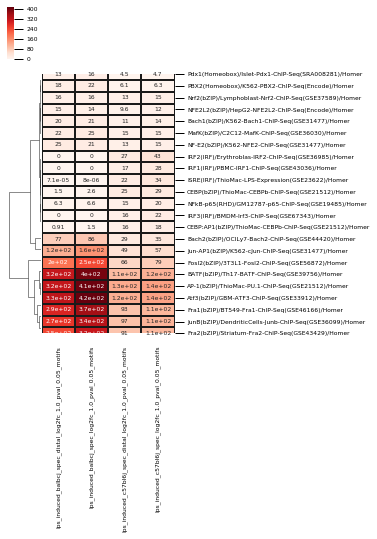

In [44]:


sns.clustermap(
    -tmp_frame.loc[top_motifs, :],
    cmap='Reds',
    linewidths=1,
    linecolor='k',
    annot=True,
#     cbar_kws={'label': '-log10(pval)',
#               'labelsize': 6},
    col_cluster=False,
    # square=True,
    # center=0,
    # ax=ax,
    # col_colors=['#de2d26', '#3182bd', '#31a354'],
    figsize=(3,6))

# plt.savefig('./figures/known_motif_strain_specific_intersection_enhancers.png',
#             bbox_inches='tight')

### Select motifs with highest score difference

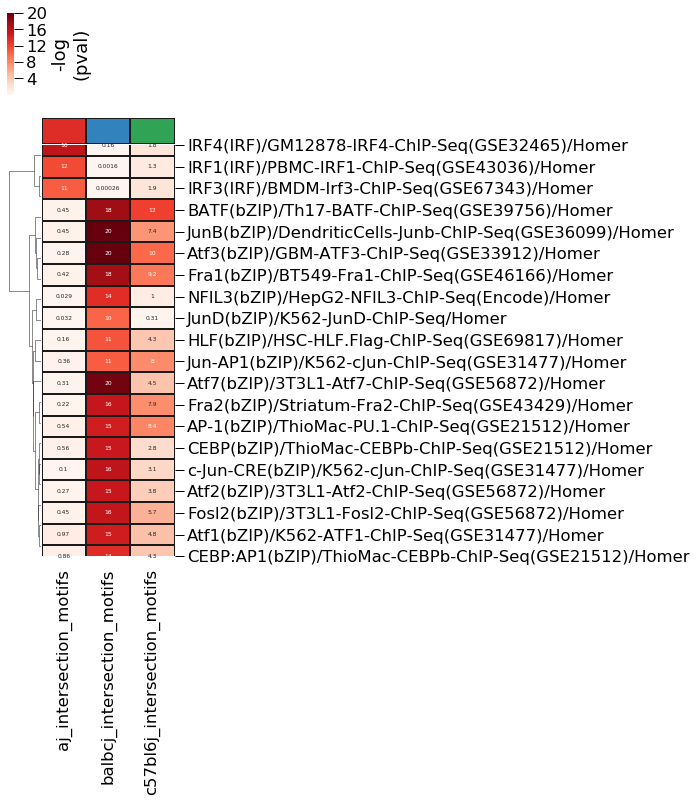

In [19]:
sns.clustermap(
    -tmp_frame.loc[(tmp_frame.max(1)-tmp_frame.min(1)).sort_values(ascending=False).index.tolist(), :].head(20),
    cmap='Reds',
    linewidths=1,
    linecolor='k',
    annot=True,
    cbar_kws={'label': '-log\n(pval)'},
    col_cluster=False,
    # square=True,
    # center=0,
    # ax=ax,
    col_colors=['#de2d26', '#3182bd', '#31a354',],
    figsize=(3,10))

plt.savefig('./figures/known_motif_strain_specific_intersection_rankdiff_enhancers.png',
            bbox_inches='tight')

## Plot union motifs

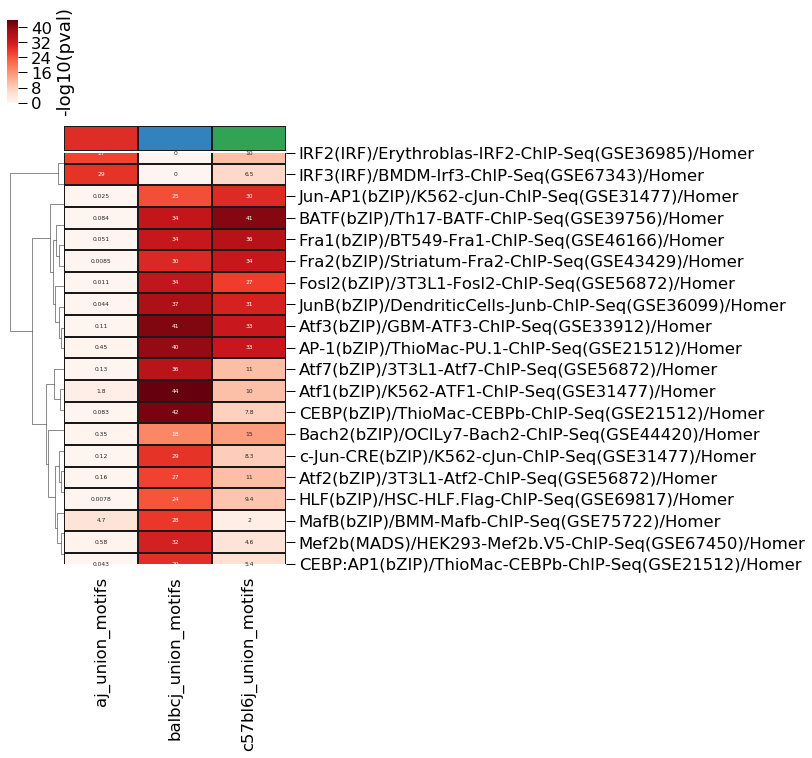

In [20]:
tmp_frame = known_motif_pval_frame.loc[:, known_motif_pval_frame.columns.str.contains('union')]
tmp_frame = tmp_frame.loc[:, ~tmp_frame.columns.str.contains('distal')]
tmp_frame = tmp_frame.loc[:, ~tmp_frame.columns.str.contains('nobg_nodenovo')]


# sort by new mean
tmp_frame = tmp_frame.reindex(tmp_frame.mean(axis=1).sort_values(ascending=True).index.tolist())


sns.clustermap(
    -tmp_frame.loc[(known_motif_pval_frame <=-5).any(axis=1), :].head(20),
    cmap='Reds',
    linewidths=1,
    linecolor='k',
    annot=True,
    cbar_kws={'label': '-log10(pval)'},
    col_cluster=False,
    # square=True,
    # center=0,
    # ax=ax,
    col_colors=['#de2d26', '#3182bd', '#31a354'],
    figsize=(5,10))

plt.savefig('./figures/known_motif_strain_specific_union_enhancers.png',
            bbox_inches='tight')

### Select motifs with highest score difference

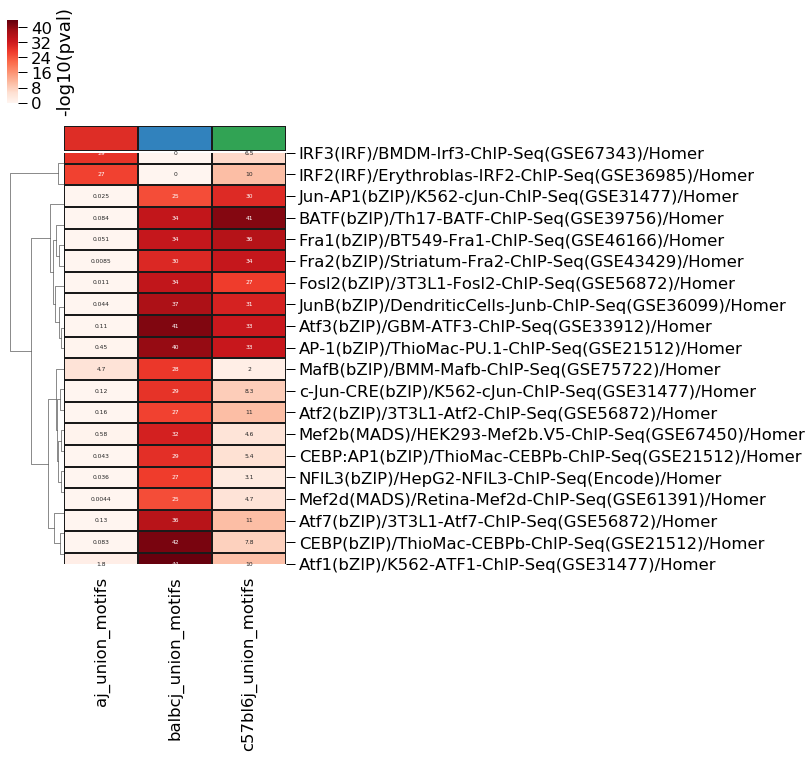

In [21]:
sns.clustermap(
    -tmp_frame.loc[(tmp_frame.max(1)-tmp_frame.min(1)).sort_values(ascending=False).index.tolist(), :].head(20),
    cmap='Reds',
    linewidths=1,
    linecolor='k',
    annot=True,
    cbar_kws={'label': '-log10(pval)'},
    col_cluster=False,
    # square=True,
    # center=0,
    # ax=ax,
    col_colors=['#de2d26', '#3182bd', '#31a354'],
    figsize=(5,10))

plt.savefig('./figures/known_motif_strain_specific_union_rankdiff_enhancers.png',
            bbox_inches='tight')

# Distal motifs

## Plot intersection distal motifs

In [ ]:
tmp_frame = known_motif_pval_frame.loc[:, known_motif_pval_frame.columns.str.contains('intersection')]
tmp_frame = tmp_frame.loc[:, tmp_frame.columns.str.contains('distal')]

# sort by new mean
tmp_frame = tmp_frame.reindex(tmp_frame.mean(axis=1).sort_values(ascending=True).index.tolist())


sns.clustermap(
    -tmp_frame.loc[(known_motif_pval_frame <=-5).any(axis=1), :].head(20),
    cmap='Reds',
    linewidths=1,
    linecolor='k',
    annot=True,
    cbar_kws={'label': '-log10(pval)'},
    col_cluster=False,
    # square=True,
    # center=0,
    # ax=ax,
    col_colors=['#de2d26', '#3182bd', '#31a354'],
    figsize=(5,10))

plt.savefig('./figures/known_motif_strain_specific_intersection_distal_enhancers.png',
            bbox_inches='tight')

### Select motifs with highest score difference

In [ ]:
sns.clustermap(
    -tmp_frame.loc[(tmp_frame.max(1)-tmp_frame.min(1)).sort_values(ascending=False).index.tolist(), :].head(20),
    cmap='Reds',
    linewidths=1,
    linecolor='k',
    annot=True,
    cbar_kws={'label': '-log10(pval)'},
    col_cluster=False,
    # square=True,
    # center=0,
    # ax=ax,
    col_colors=['#de2d26', '#3182bd', '#31a354'],
    figsize=(5,10))

plt.savefig('./figures/known_motif_strain_specific_intersection_rankdiff_distal_enhancers.png',
            bbox_inches='tight')

## Plot union distal motifs

In [ ]:
tmp_frame = known_motif_pval_frame.loc[:, known_motif_pval_frame.columns.str.contains('union')]
tmp_frame = tmp_frame.loc[:, tmp_frame.columns.str.contains('distal')]

# sort by new mean
tmp_frame = tmp_frame.reindex(tmp_frame.mean(axis=1).sort_values(ascending=True).index.tolist())


sns.clustermap(
    -tmp_frame.loc[(known_motif_pval_frame <=-5).any(axis=1), :].head(20),
    cmap='Reds',
    linewidths=1,
    linecolor='k',
    annot=True,
    cbar_kws={'label': '-log10(pval)'},
    col_cluster=False,
    # square=True,
    # center=0,
    # ax=ax,
    col_colors=['#31a354', '#3182bd', '#de2d26'],
    figsize=(5,10))

plt.savefig('./figures/known_motif_strain_specific_union_distal_enhancers.png',
            bbox_inches='tight')

### Select motifs with highest score difference

In [ ]:
sns.clustermap(
    -tmp_frame.loc[(tmp_frame.max(1)-tmp_frame.min(1)).sort_values(ascending=False).index.tolist(), :].head(20),
    cmap='Reds',
    linewidths=1,
    linecolor='k',
    annot=True,
    cbar_kws={'label': '-log10(pval)'},
    col_cluster=False,
    # square=True,
    # center=0,
    # ax=ax,
    col_colors=['#31a354', '#3182bd', '#de2d26'],
    figsize=(5,10))

plt.savefig('./figures/known_motif_strain_specific_union_rankdiff_distal_enhancers.png',
            bbox_inches='tight')

# Annotate motifs that were found...

A key finding here is the enrichment of the IRF4 motif in AJ mice, because leptin receptor treatment appears to repress IRF signaling in KCs and AJ mice express almost no leptin receptor.

In [ ]:
if not os.path.isdir('./motif_scanning'):
    os.mkdir('./motif_scanning')

    annotatePeaks.pl ./motif_calling/aj_intersection_act_peaks.txt \
    mm10 -m /bioinformatics/homer/motifs/irf4.motif \
    > ./motif_scanning/aj_intersection_act_peaks_annoIRF4.txt
    
    annotatePeaks.pl ./motif_calling/aj_intersection_act_peaks.txt \
    mm10 -m /bioinformatics/homer/motifs/irf3.motif \
    > ./motif_scanning/aj_intersection_act_peaks_annoIRF3.txt

In [29]:
import scipy.stats as stats

In [31]:
help(stats.binom)

Help on binom_gen in module scipy.stats._discrete_distns object:

class binom_gen(scipy.stats._distn_infrastructure.rv_discrete)
 |  binom_gen(a=0, b=inf, name=None, badvalue=None, moment_tol=1e-08, values=None, inc=1, longname=None, shapes=None, extradoc=None, seed=None)
 |  
 |  A binomial discrete random variable.
 |  
 |  %(before_notes)s
 |  
 |  Notes
 |  -----
 |  The probability mass function for `binom` is:
 |  
 |  .. math::
 |  
 |     f(k) = \binom{n}{k} p^k (1-p)^{n-k}
 |  
 |  for ``k`` in ``{0, 1,..., n}``.
 |  
 |  `binom` takes ``n`` and ``p`` as shape parameters.
 |  
 |  %(after_notes)s
 |  
 |  %(example)s
 |  
 |  Method resolution order:
 |      binom_gen
 |      scipy.stats._distn_infrastructure.rv_discrete
 |      scipy.stats._distn_infrastructure.rv_generic
 |      builtins.object
 |  
 |  Methods inherited from scipy.stats._distn_infrastructure.rv_discrete:
 |  
 |  __init__(self, a=0, b=inf, name=None, badvalue=None, moment_tol=1e-08, values=None, inc=1, long